In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import seaborn as sns


In [2]:
ds_root_erp = '../results/erp'
ds_root_behavior = '../results/joint-modeling'

## Logic for plots
In this script, we plot single-trial CPP traces which was used to check the validity of CPP processing. Logically, the amplitude of response-locked CPP will peak before or after the response in per trial.

For each trial, we epoched 601 timestamps which include 1 timestamp for response, 1s * 500=500 timestamps before response and 0.2 * 500=100 timestamps after response. However, the time when subjects make a response are different. 

According to the logic above, we use heapmap to check whether CPP amplitude peak before or after the response. Additionally, because our goal aims to put all trials in a plot, we sort the RT for all of the trials at first. Then, we can draw a line, which links the time point when the subject made a response, in a "RT-trial" plot. In this plot, the X-axis represents RT which range from 0 to the maximun RT for all of the trials. The Y-axis represents the index of trials which were sorted by RT . Lastly, we plot heapmap for the amplitude of response-locked CPP before and after response.


## The meaning of codes
The basic logic to achieve the plot in above is following:

1️⃣ Load and merge CPP and behavior data for each trial. Note that we change unit into µV. Then, sort all trials in descending RT.

2️⃣ Calculate the end time for each trial and then change it into discrete timestamps, which was calculated as '(rt + 0.2s) * 500Hz'. According to the end time, we can locate the last column for CPP data for each trial. The reason why we need the end index of CPP data is that, some trials with short RT can not index the start time easily. But we can fill the epoch from the end index.

3️⃣ Set the zero matrix for the shape of (n_trials, timestamps for longest end time). In this matrix, each row has a lot of columns. We just need to fill the CPP data in certain places according to the range of response. To achieve this, we use 'for loop' to loop through all rows. Note that, some trials with short RT need to fill from the last column of CPP.

4️⃣ Plot figures in a normal way.


In [20]:
# load CPP data which was saved according to script 2. Note that the shape of these data  is (n_trials, channels, timestamps)
sub_dir = [f'A{i:03}' for i in range(1,21)]
data_CPP_all = []
for sub in sub_dir:
    data_CPP = scipy.io.loadmat(os.path.join(ds_root_erp, 'erp_'+'sub-'+sub+'.mat'))['erp']
    data_CPP_all.append(data_CPP)

# concatenate data and averge them by 3 channels to acquire CPP
data_CPP_all = np.concatenate(data_CPP_all, axis=0)
data_CPP_all = np.mean(data_CPP_all, axis=1)
data_CPP_all = pd.DataFrame(data_CPP_all)

# change unit into µV by dividing CPP by 1e6
data_CPP_all = data_CPP_all/1e6

# load RT to locate the time when the subject made a response
data_behavior = pd.read_csv(os.path.join(ds_root_behavior, 'joint_modeling_all.csv'))
data_behavior_plot = data_behavior[['subj','RT']]

# merge the behavior and CPP data
data_beha_CPP = pd.concat([data_behavior_plot, data_CPP_all], axis=1)

# sort the row of dataset by descending RT
data_sorted = data_beha_CPP.sort_values('RT', ascending=False)

# make continious time into discrete columns
data_sorted['rt_end'] = (data_sorted['RT']+0.2)*500
data_sorted = data_sorted.reset_index(drop=True)

# Find the longest RT and set zero matrix, which facilitate us fill empty time for each trial
t_max = int((data_sorted['RT'].max()+0.2)*500) # 500 represents sampling rate; making 0.2s after response because the range of response-locked CPP amplitude is [-1, 0.2]
data_plot = np.zeros((data_sorted.shape[0], t_max))

# From the third column to the last one are the data of CPP for the array of 'data_sorted' 
cpp_columns = data_sorted.columns[2:-1] 

# Loop through each row
for idx, row in data_sorted.iterrows():
    rt_end = int(row['rt_end']) 
    rt_start = max(0, (rt_end - int(1.2 * 500))) # because in some trials, RT is shorter than 1s. We set 0 as the minimum start time.
    cpp_data = row[cpp_columns].values

    target_length = rt_end - rt_start
    if len(cpp_data) != target_length:
        cpp_data = cpp_data[-target_length:] # if the length of CPP data is less than [-1.2, 1], we fill the CPP data from the last column

    data_plot[idx, rt_start:rt_end] = cpp_data



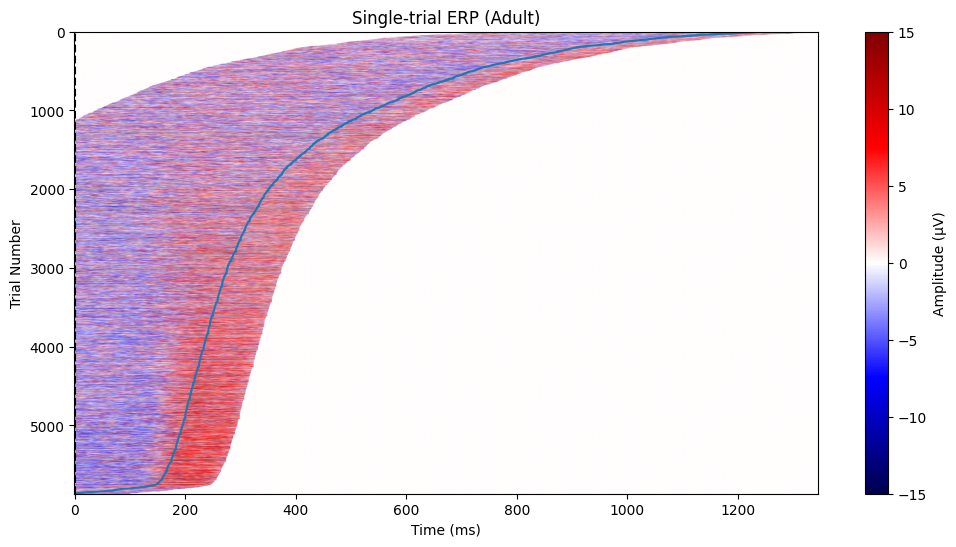

In [21]:
plt.figure(figsize=(12, 6))
plt.imshow(data_plot, 
           aspect='auto',
           cmap='seismic',
           vmin=-15, vmax=15,
)

plt.plot(data_sorted['RT'].to_numpy()*500, range(len(data_sorted)))
plt.axvline(0, color='k', linestyle='--') 
plt.colorbar(label='Amplitude (μV)')
plt.xlabel('Time (ms)')
plt.ylabel('Trial Number')
plt.title('Single-trial ERP (Adult)')
plt.show()